<a href="https://colab.research.google.com/github/gndumbri/Thinkful-Capstone-II---Supervised-Machine-Learning/blob/master/Thinkful_Capstone_II_Machine_Learning_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Foreign Donations in Higher Education

This capstone is concerned with using supervised machine learning to predict the amount of foreign donations to institutions of higher education in the United States. 

Donations and Philanthropy are typically sums of money handled by staff working as "Advancement", or "Development" officers in Colleges & Universities in the United States. Their primary goal is to solicit funds for any number of uses at their respective institution. Often these donors are alumni, but they may be corporate partners, or in the case of this capstone, foreign entities.

As donated funds directly tie into the operating budget of Colleges & Universities, the business significance of this project would be to help Advancement or Development officers by creating a predictive model to aid in goal-setting for the amount to be expected in an individual donation from a foreign entity. 

This project also attempts to model the total amount of foreign donations per year.

In [0]:
# Setting up Colab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import stats
from google.colab import drive 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
import warnings

In [0]:
# Handle warnings

warnings.filterwarnings('ignore')

To do this, I sourced data from 3 locations: The aggregated [Education Data Set](https://https://educationdata.urban.org/data-explorer/colleges/) found through the Thinkful data resources, Foreign Donation Data available from [FAFSA.gov](https://studentaid.gov/data-center/school/foreign-gifts), and U.S. News and World Reports rankings of the 50 best colleges & universities in the U.S.(citation: Andrew G. Reiter, “U.S. News & World Report Historical Liberal Arts College and University Rankings,” available at: http://andyreiter.com/datasets/)

In [0]:
# Mount Google Drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Load Data Sets

df = pd.read_csv('gdrive/My Drive/EducationDataPortal_01.15.2020_institutions.csv')
df2 = pd.read_csv('gdrive/My Drive/ForeignGifts.csv', skiprows=1)
df3 = pd.read_csv('gdrive/My Drive/US-News-Rankings-Universities-Through-2020.csv', skiprows=1)

I started by inspecting each Data Set as well as identifying and cleaning columns on which to merge the 3 dataframes

In [0]:
df.head()

,year,unitid,inst_name,state_name,number_applied,number_admitted,number_enrolled_ft,number_enrolled_pt,number_enrolled_total,offering_highest_level,inst_control,institution_level,sector,hbcu,primarily_postsecondary,hospital,medical_degree,tribal_college,opeid,offering_highest_degree,title_iv_indicator,offering_undergrad,offering_grad,degree_granting,open_public,postsec_public_active,postsec_public_active_title_iv,inst_system_flag,inst_category,land_grant,inst_size,inst_alias,cc_basic_2015,inst_status,dist_ug_offered,dist_grad_offered,remedial_services,academic_counseling,employment_services,placement_services,oncampus_daycare,oncampus_housing,oncampus_required,tuition_guaranteed,prepaid_tuition,tuition_payment_plan,member_ncaa,study_abroad
0,2017,100654,Alabama A & M University,Alabama,8610.0,7772.0,1288.0,6.0,1294.0,Doctor's degree,Public,Four or more years,"Public, four-year or above",Yes,Yes,No,No,No,00100200,"Doctor's degree, research/scholarship",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",Yes,"5,000-9,999",AAMU,Master's colleges & universities: larger programs,Active - institution,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes
1,2017,100663,University of Alabama at Birmingham,Alabama,7555.0,6936.0,2228.0,71.0,2299.0,Doctor's degree,Public,Four or more years,"Public, four-year or above",No,Yes,Yes,Yes,No,00105200,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,Yes,"Degree-granting, primarily baccalaureate or above",No,"20,000 and above",,Doctoral universities: highest research activity,Active - institution,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,Yes
2,2017,100690,Amridge University,Alabama,NaN,NaN,NaN,NaN,NaN,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,02503400,"Doctor's degree, research/scholarship",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"Under 1,000",Southern Christian University |Regions University,Master's colleges & universities: small programs,Active - institution,Yes,Yes,No,Yes,Yes,No,No,No,No,Yes,No,No,No,No
3,2017,100706,University of Alabama in Huntsville,Alabama,4454.0,3618.0,1341.0,11.0,1352.0,Doctor's degree,Public,Four or more years,"Public, four-year or above",No,Yes,No,No,No,00105500,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,Yes,"Degree-granting, primarily baccalaureate or above",No,"5,000-9,999",UAH |University of Alabama Huntsville,Doctoral universities: higher research activity,Active - institution,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes
4,2017,100724,Alabama State University,Alabama,6842.0,6696.0,951.0,16.0,967.0,Doctor's degree,Public,Four or more years,"Public, four-year or above",Yes,Yes,No,No,No,00100500,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"1,000-4,999",,Master's colleges & universities: medium programs,Active - institution,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,Yes


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19402 entries, 0 to 19401
Data columns (total 48 columns):
year                              19402 non-null int64
unitid                            19402 non-null int64
inst_name                         19402 non-null object
state_name                        19402 non-null object
number_applied                    11302 non-null float64
number_admitted                   11263 non-null float64
number_enrolled_ft                11239 non-null float64
number_enrolled_pt                9739 non-null float64
number_enrolled_total             11263 non-null float64
offering_highest_level            19402 non-null object
inst_control                      19402 non-null object
institution_level                 19402 non-null object
sector                            19402 non-null object
hbcu                              19402 non-null object
primarily_postsecondary           19402 non-null object
hospital                          19402 non-null 

In [0]:
df['opeid'].value_counts()

Not applicable    83
202500            12
370200             8
146900             8
931309             8
                  ..
305143             1
01289600           1
3115002            1
4243900            1
03092700           1
Name: opeid, Length: 6543, dtype: int64

In [0]:
df = df[df['opeid'] != 'Not applicable']
df = df[df['opeid'] != ' ']

df['opeid'] = pd.to_numeric(df['opeid'])

In [0]:
df2.head()

,ID,OPEID,Institution Name,City,State,Foreign Gift Received Date,Foreign Gift Amount,Gift Type,Country of Giftor,Giftor Name
0,1,324200,Carnegie Mellon University,Pittsburgh,PA,01/01/2015,"$77,391,377.00",Contract,QATAR,Qatar Foundation for Education
1,2,143400,American University (The),Washington,DC,01/25/2012,"$500,000.00",Monetary Gift,BAHRAIN,Kingdom of Bahrain
2,3,143400,American University (The),Washington,DC,05/28/2013,"$500,000.00",Monetary Gift,BAHRAIN,Sheikh Salman Bin Al-Khalifa
3,4,143400,American University (The),Washington,DC,09/10/2015,"$500,000.00",Monetary Gift,KUWAIT,NaN
4,5,143400,American University (The),Washington,DC,05/17/2012,"$610,000.00",Monetary Gift,ENGLAND,NaN


In [0]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21052 entries, 0 to 21051
Data columns (total 10 columns):
ID                            21052 non-null int64
OPEID                         21052 non-null int64
Institution Name              21052 non-null object
City                          21052 non-null object
State                         21052 non-null object
Foreign Gift Received Date    21052 non-null object
Foreign Gift Amount           21052 non-null object
Gift Type                     21052 non-null object
Country of Giftor             21052 non-null object
Giftor Name                   17805 non-null object
dtypes: int64(2), object(8)
memory usage: 1.6+ MB


Clean Data for merging dataframes and feature selection/engineering

In [0]:
df2.rename(columns=dict([(x,x.strip()) for x in df2.columns]))
df2.head()

,ID,OPEID,Institution Name,City,State,Foreign Gift Received Date,Foreign Gift Amount,Gift Type,Country of Giftor,Giftor Name
0,1,324200,Carnegie Mellon University,Pittsburgh,PA,01/01/2015,"$77,391,377.00",Contract,QATAR,Qatar Foundation for Education
1,2,143400,American University (The),Washington,DC,01/25/2012,"$500,000.00",Monetary Gift,BAHRAIN,Kingdom of Bahrain
2,3,143400,American University (The),Washington,DC,05/28/2013,"$500,000.00",Monetary Gift,BAHRAIN,Sheikh Salman Bin Al-Khalifa
3,4,143400,American University (The),Washington,DC,09/10/2015,"$500,000.00",Monetary Gift,KUWAIT,NaN
4,5,143400,American University (The),Washington,DC,05/17/2012,"$610,000.00",Monetary Gift,ENGLAND,NaN


In [0]:
df2['Foreign Gift Amount'] = df2['Foreign Gift Amount'].str.replace('$', '')
df2['Foreign Gift Amount'] = df2['Foreign Gift Amount'].str.replace(',', '')
df2['Foreign Gift Amount'] = pd.to_numeric(df2['Foreign Gift Amount'])

df2['Foreign Gift Received Date'] = pd.to_datetime(df2['Foreign Gift Received Date'])
df2 = df2.assign(year=df2['Foreign Gift Received Date'].dt.year)

df2 = df2[df2['year'] != 2018]

One final check of merge columns for df and df 2

In [0]:
print(np.sort(df2['year'].unique()))
print(np.sort(df['year'].unique()))
print(df2['OPEID'].nunique())
print(df['opeid'].nunique())

[2012 2013 2014 2015 2016 2017]
[2012 2013 2014 2015 2016 2017]
156
3525


Repeat cleaning and inspection for df3

In [0]:
df3.head()

,University Name,IPEDS ID,State,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992,1991,1990,1989,1988,1986,1984
0,Princeton University,186131,NJ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,4.0,2.0,2.0,4.0,4.0,4.0
1,Harvard University,166027,MA,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,2.0,2.0,2.0
2,Columbia University,190150,NY,3.0,3.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,8.0,8.0,9.0,9.0,9.0,9.0,11.0,10.0,9.0,10.0,10.0,10.0,9.0,11.0,15.0,9.0,11.0,10.0,9.0,10.0,11.0,8.0,18.0,NaN,NaN
3,Massachusetts Institute of Technology,166683,MA,3.0,3.0,5.0,7.0,7.0,7.0,7.0,6.0,5.0,7.0,4.0,4.0,7.0,4.0,7.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,6.0,5.0,5.0,4.0,4.0,5.0,6.0,6.0,7.0,5.0,11.0,11.0,10.0
4,University of Chicago,144050,IL,6.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,5.0,9.0,8.0,8.0,9.0,9.0,15.0,14.0,13.0,12.0,9.0,10.0,13.0,14.0,14.0,12.0,11.0,10.0,9.0,9.0,10.0,11.0,9.0,10.0,8.0,5.0,6.0


In [0]:
df3.drop(df3.iloc[:,np.r_[2:6, 12:38]], axis=1, inplace=True)

In [0]:
year_list = ['2012', '2013', '2014', '2015', '2016', '2017']

for i in df3[year_list]:
    df3[i][df3[i] > 0 ] = i

In [0]:
df3 = pd.melt(df3, id_vars=['University Name', 'IPEDS ID'], 
              value_vars=['2017', '2016', '2015', '2014', '2013', '2012'])

In [0]:
df3.rename(columns={'variable':'year','value':'Top50'}, inplace=True)

In [0]:
df3['Top50'].isna().sum()

63

In [0]:
df3['Top50'][df3['Top50'] == '2017'] = 1
df3['Top50'][df3['Top50'] == '2016'] = 1
df3['Top50'][df3['Top50'] == '2015'] = 1
df3['Top50'][df3['Top50'] == '2014'] = 1
df3['Top50'][df3['Top50'] == '2013'] = 1
df3['Top50'][df3['Top50'] == '2012'] = 1

In [0]:
df3['Top50'].fillna(value=0, inplace=True)

In [0]:
df3['year'].dtypes

dtype('O')

In [0]:
df3['year'] = pd.to_numeric(df3['year'])

In [0]:
df3

,University Name,IPEDS ID,year,Top50
0,Princeton University,186131,2017,1
1,Harvard University,166027,2017,1
2,Columbia University,190150,2017,1
3,Massachusetts Institute of Technology,166683,2017,1
4,University of Chicago,144050,2017,1
...,...,...,...,...
361,Syracuse University,196413,2012,0
362,Texas A&M University-College Station,228723,2012,0
363,University of Miami,135726,2012,1
364,University of Washington,236948,2012,1


In [0]:
print(df.shape)
print(df2.shape)
print(df3.shape)

(19315, 48)
(18073, 11)
(366, 4)


Merge df, df2, and df3 and inspect

In [0]:
merged = pd.merge(df2, df, how='left', left_on=['year', 'OPEID'], 
                  right_on=['year', 'opeid'])

In [0]:
merged.shape

(18364, 58)

In [0]:
merged.head()

,ID,OPEID,Institution Name,City,State,Foreign Gift Received Date,Foreign Gift Amount,Gift Type,Country of Giftor,Giftor Name,year,unitid,inst_name,state_name,number_applied,number_admitted,number_enrolled_ft,number_enrolled_pt,number_enrolled_total,offering_highest_level,inst_control,institution_level,sector,hbcu,primarily_postsecondary,hospital,medical_degree,tribal_college,opeid,offering_highest_degree,title_iv_indicator,offering_undergrad,offering_grad,degree_granting,open_public,postsec_public_active,postsec_public_active_title_iv,inst_system_flag,inst_category,land_grant,inst_size,inst_alias,cc_basic_2015,inst_status,dist_ug_offered,dist_grad_offered,remedial_services,academic_counseling,employment_services,placement_services,oncampus_daycare,oncampus_housing,oncampus_required,tuition_guaranteed,prepaid_tuition,tuition_payment_plan,member_ncaa,study_abroad
0,1,324200,Carnegie Mellon University,Pittsburgh,PA,2015-01-01,77391377.0,Contract,QATAR,Qatar Foundation for Education,2015,211440.0,Carnegie Mellon University,Pennsylvania,20547.0,4873.0,1575.0,0.0,1575.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,324200.0,"Doctor's degree, research/scholarship",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",Carnegie Mellon; CMU,Doctoral universities: highest research activity,Active - institution,Yes,Yes,No,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,Yes
1,2,143400,American University (The),Washington,DC,2012-01-25,500000.0,Monetary Gift,BAHRAIN,Kingdom of Bahrain,2012,131159.0,American University,District of Columbia,17039.0,7531.0,1592.0,3.0,1595.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,NaN,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes
2,3,143400,American University (The),Washington,DC,2013-05-28,500000.0,Monetary Gift,BAHRAIN,Sheikh Salman Bin Al-Khalifa,2013,131159.0,American University,District of Columbia,17545.0,7566.0,1624.0,3.0,1627.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,NaN,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes
3,4,143400,American University (The),Washington,DC,2015-09-10,500000.0,Monetary Gift,KUWAIT,NaN,2015,131159.0,American University,District of Columbia,16735.0,5860.0,1779.0,8.0,1787.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,Doctoral universities: higher research activity,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes
4,5,143400,American University (The),Washington,DC,2012-05-17,610000.0,Monetary Gift,ENGLAND,NaN,2012,131159.0,American University,District of Columbia,17039.0,7531.0,1592.0,3.0,1595.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof..

In [0]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18364 entries, 0 to 18363
Data columns (total 58 columns):
ID                                18364 non-null int64
OPEID                             18364 non-null int64
Institution Name                  18364 non-null object
City                              18364 non-null object
State                             18364 non-null object
Foreign Gift Received Date        18364 non-null datetime64[ns]
Foreign Gift Amount               18364 non-null float64
Gift Type                         18364 non-null object
Country of Giftor                 18364 non-null object
Giftor Name                       15673 non-null object
year                              18364 non-null int64
unitid                            18360 non-null float64
inst_name                         18360 non-null object
state_name                        18360 non-null object
number_applied                    17843 non-null float64
number_admitted                   17843 non

In [0]:
merged_2 = pd.merge(merged, df3, how='left', left_on=['year', 'unitid'], 
                    right_on=['year', 'IPEDS ID'])

In [0]:
merged_2.shape

(18364, 61)

In [0]:
merged_2.head()

,ID,OPEID,Institution Name,City,State,Foreign Gift Received Date,Foreign Gift Amount,Gift Type,Country of Giftor,Giftor Name,year,unitid,inst_name,state_name,number_applied,number_admitted,number_enrolled_ft,number_enrolled_pt,number_enrolled_total,offering_highest_level,inst_control,institution_level,sector,hbcu,primarily_postsecondary,hospital,medical_degree,tribal_college,opeid,offering_highest_degree,title_iv_indicator,offering_undergrad,offering_grad,degree_granting,open_public,postsec_public_active,postsec_public_active_title_iv,inst_system_flag,inst_category,land_grant,inst_size,inst_alias,cc_basic_2015,inst_status,dist_ug_offered,dist_grad_offered,remedial_services,academic_counseling,employment_services,placement_services,oncampus_daycare,oncampus_housing,oncampus_required,tuition_guaranteed,prepaid_tuition,tuition_payment_plan,member_ncaa,study_abroad,University Name,IPEDS ID,Top50
0,1,324200,Carnegie Mellon University,Pittsburgh,PA,2015-01-01,77391377.0,Contract,QATAR,Qatar Foundation for Education,2015,211440.0,Carnegie Mellon University,Pennsylvania,20547.0,4873.0,1575.0,0.0,1575.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,324200.0,"Doctor's degree, research/scholarship",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",Carnegie Mellon; CMU,Doctoral universities: highest research activity,Active - institution,Yes,Yes,No,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,Yes,Carnegie Mellon University,211440.0,1.0
1,2,143400,American University (The),Washington,DC,2012-01-25,500000.0,Monetary Gift,BAHRAIN,Kingdom of Bahrain,2012,131159.0,American University,District of Columbia,17039.0,7531.0,1592.0,3.0,1595.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,NaN,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN
2,3,143400,American University (The),Washington,DC,2013-05-28,500000.0,Monetary Gift,BAHRAIN,Sheikh Salman Bin Al-Khalifa,2013,131159.0,American University,District of Columbia,17545.0,7566.0,1624.0,3.0,1627.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,NaN,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN
3,4,143400,American University (The),Washington,DC,2015-09-10,500000.0,Monetary Gift,KUWAIT,NaN,2015,131159.0,American University,District of Columbia,16735.0,5860.0,1779.0,8.0,1787.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,Doctoral universities: higher research activity,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN
4,5,143400,American University (The),Washington,DC,2012-05-17,610000.0,Monetary Gift,ENGLAND,NaN,2012,131159.0,American University,District of Columbia,17039.0,7531.0,1592.0,3.0,1595.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not

In [0]:
merged_2.rename(columns=dict([(x,x.strip()) for x in merged_2.columns]))

,ID,OPEID,Institution Name,City,State,Foreign Gift Received Date,Foreign Gift Amount,Gift Type,Country of Giftor,Giftor Name,year,unitid,inst_name,state_name,number_applied,number_admitted,number_enrolled_ft,number_enrolled_pt,number_enrolled_total,offering_highest_level,inst_control,institution_level,sector,hbcu,primarily_postsecondary,hospital,medical_degree,tribal_college,opeid,offering_highest_degree,title_iv_indicator,offering_undergrad,offering_grad,degree_granting,open_public,postsec_public_active,postsec_public_active_title_iv,inst_system_flag,inst_category,land_grant,inst_size,inst_alias,cc_basic_2015,inst_status,dist_ug_offered,dist_grad_offered,remedial_services,academic_counseling,employment_services,placement_services,oncampus_daycare,oncampus_housing,oncampus_required,tuition_guaranteed,prepaid_tuition,tuition_payment_plan,member_ncaa,study_abroad,University Name,IPEDS ID,Top50
0,1,324200,Carnegie Mellon University,Pittsburgh,PA,2015-01-01,77391377.0,Contract,QATAR,Qatar Foundation for Education,2015,211440.0,Carnegie Mellon University,Pennsylvania,20547.0,4873.0,1575.0,0.0,1575.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,324200.0,"Doctor's degree, research/scholarship",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",Carnegie Mellon; CMU,Doctoral universities: highest research activity,Active - institution,Yes,Yes,No,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,Yes,Carnegie Mellon University,211440.0,1.0
1,2,143400,American University (The),Washington,DC,2012-01-25,500000.0,Monetary Gift,BAHRAIN,Kingdom of Bahrain,2012,131159.0,American University,District of Columbia,17039.0,7531.0,1592.0,3.0,1595.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,NaN,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN
2,3,143400,American University (The),Washington,DC,2013-05-28,500000.0,Monetary Gift,BAHRAIN,Sheikh Salman Bin Al-Khalifa,2013,131159.0,American University,District of Columbia,17545.0,7566.0,1624.0,3.0,1627.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,NaN,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN
3,4,143400,American University (The),Washington,DC,2015-09-10,500000.0,Monetary Gift,KUWAIT,NaN,2015,131159.0,American University,District of Columbia,16735.0,5860.0,1779.0,8.0,1787.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not-for-profit, four-year or above",No,Yes,No,No,No,143400.0,"Doctor's degree, research/scholarship and prof...",Participates in Title IV federal financial aid...,Yes,Yes,Yes,Yes,Active postsecondary institution,Title IV postsecondary institution,No,"Degree-granting, primarily baccalaureate or above",No,"10,000-19,999",,Doctoral universities: higher research activity,Active - institution,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,Yes,Yes,Yes,Yes,NaN,NaN,NaN
4,5,143400,American University (The),Washington,DC,2012-05-17,610000.0,Monetary Gift,ENGLAND,NaN,2012,131159.0,American University,District of Columbia,17039.0,7531.0,1592.0,3.0,1595.0,Doctor's degree,Private not-for-profit,Four or more years,"Private not

### Exploratory Data Analysis

Begin Exploratory Data Analysis

In [0]:
continuous_vars = [col for col in merged_2 if merged_2[col].dtypes != 'object']

In [0]:
merged_2[continuous_vars].nunique()

ID                            18073
OPEID                           156
Foreign Gift Received Date     1848
Foreign Gift Amount           10397
year                              6
unitid                          162
number_applied                  552
number_admitted                 547
number_enrolled_ft              532
number_enrolled_pt              125
number_enrolled_total           537
opeid                           155
IPEDS ID                         47
Top50                             2
dtype: int64

Remove non-explanatory continuous variables from dataframe (i.e. 'ID', 'OPEID', 'unitd')

In [0]:
remove_cont_var = ['ID', 'opeid', 'OPEID', 'opeid', 'unitid', 
               'Foreign Gift Received Date', 'IPEDS ID', 'year']
keep_cont_var = [i for i in continuous_vars if i not in remove_cont_var]

In [0]:
# Look for correlations with target among continuous variables

merged_2[keep_cont_var].corr()

,Foreign Gift Amount,number_applied,number_admitted,number_enrolled_ft,number_enrolled_pt,number_enrolled_total,Top50
Foreign Gift Amount,1.000000,-0.032834,-0.028937,-0.018912,0.072833,-0.016723,-0.031842
number_applied,-0.032834,1.000000,0.646739,0.726719,-0.097066,0.712533,0.051098
number_admitted,-0.028937,0.646739,1.000000,0.920744,0.219579,0.919247,-0.238678
number_enrolled_ft,-0.018912,0.726719,0.920744,1.000000,0.253545,0.998590,-0.234227
number_enrolled_pt,0.072833,-0.097066,0.219579,0.253545,1.000000,0.315262,-0.625845
number_enrolled_total,-0.016723,0.712533,0.919247,0.998590,0.315262,1.000000,-0.264574
Top50,-0.031842,0.051098,-0.238678,-0.234227,-0.625845,-0.264574,1.000000


Remove number_enrolled_pt due to heavy missing data and fill missing values in other continuous variables with interpolation

In [0]:
keep_cont_var.remove('number_enrolled_pt')

merged_2['Top50'].fillna(value=0, inplace=True)

In [0]:
merged_2[keep_cont_var].isna().sum()

Foreign Gift Amount        0
number_applied           521
number_admitted          521
number_enrolled_ft       521
number_enrolled_total    521
Top50                      0
dtype: int64

In [0]:
for column in merged_2[keep_cont_var]:
    merged_2[column].fillna(merged_2[column].interpolate(method='linear'), inplace=True)

In [0]:
merged_2[keep_cont_var].isna().sum()

Foreign Gift Amount      0
number_applied           0
number_admitted          0
number_enrolled_ft       0
number_enrolled_total    0
Top50                    0
dtype: int64

Checking features for outliers

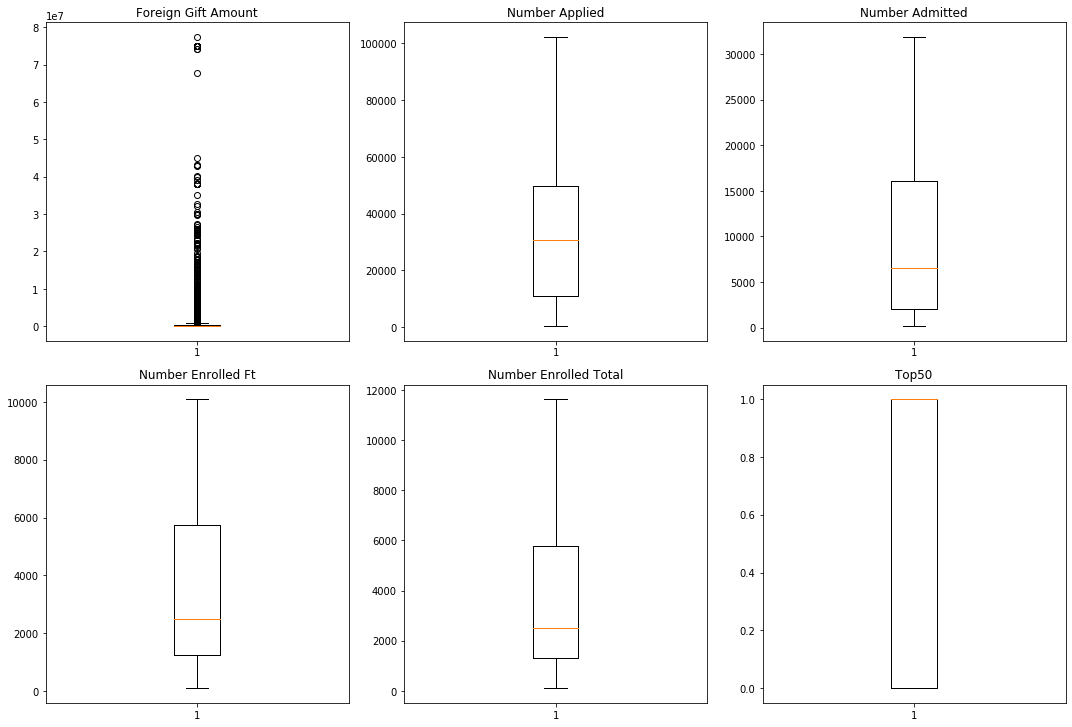

In [0]:
plt.figure(figsize=(15,15))
for i, col in enumerate(merged_2[keep_cont_var]):
    plt.subplot(3,3, i+1)
    plt.boxplot(merged_2[col])
    plt.title(col.title().replace('_', ' '))

plt.tight_layout()
plt.show()

In [0]:
categorical_vars = [col for col in merged_2 if merged_2[col].dtypes == 'object']

In [0]:
merged_2[categorical_vars].nunique()

Institution Name                   155
City                               132
State                               37
Gift Type                            3
Country of Giftor                  140
Giftor Name                       6226
inst_name                          168
state_name                          37
offering_highest_level               5
inst_control                         3
institution_level                    1
sector                               4
hbcu                                 2
primarily_postsecondary              1
hospital                             3
medical_degree                       3
tribal_college                       1
offering_highest_degree              6
title_iv_indicator                   2
offering_undergrad                   2
offering_grad                        2
degree_granting                      1
open_public                          1
postsec_public_active                2
postsec_public_active_title_iv       2
inst_system_flag         

Remove variables with several unique values, non-explanatory, or redudnant variables to reduce dimensionality of model

In [0]:
remove_cat = ['inst_alias','City', 'State', 'Giftor Name',
          'state_name', 'Institution Name', 'inst_name',
          'degree_granting', 'open_public', 'tribal_college',
          'primarily_postsecondary', 'institution_level', 'University Name']

In [0]:
keep_cat_var = [i for i in categorical_vars if i not in remove_cat]
len(keep_cat_var)

34

Inspect categorical features of interest for model

In [0]:
for i in merged_2[keep_cat_var]:
    print('{}'.format(i))
    print(merged_2[i].value_counts(), '\n')

Gift Type
Contract         10371
Monetary Gift     7991
Real Estate          2
Name: Gift Type, dtype: int64 

Country of Giftor
ENGLAND                2494
CANADA                 1849
JAPAN                  1543
CHINA                  1301
FRANCE                 1157
                       ... 
CROATIA                   1
TOKELAU                   1
LATVIA                    1
PALESTINE, STATE OF       1
CURAçAO                   1
Name: Country of Giftor, Length: 140, dtype: int64 

offering_highest_level
Doctor's degree                  17781
Post-master's certificate          376
Master's degree                    170
Bachelor's degree                   32
Postbaccalaureate certificate        1
Name: offering_highest_level, dtype: int64 

inst_control
Private not-for-profit    9918
Public                    8418
Private for-profit          24
Name: inst_control, dtype: int64 

sector
Private not-for-profit, four-year or above    9918
Public, four-year or above                    82

Remove categorical variables where the difference in means and value counts is so disproportionate that the variable is essentially representing one value, as well as remove duplicate categories

In [0]:
remove_cat.extend(['postsec_public_active', 'postsec_public_active_title_iv',
                   'inst_system_flag', 'sector', 'hbcu', 'inst_status',
                   'offering_grad', 'offering_undergrad', 'title_iv_indicator',
                   'land_grant', 'offering_highest_level', 'inst_category',
                   'academic_counseling', 'placement_services', 'employment_services',
                   'tuition_guaranteed', 'tuition_payment_plan','study_abroad',
                   'member_ncaa', 'oncampus_housing'])

keep_cat_var = [i for i in categorical_vars if i not in remove_cat]

Identify categorical features and graph their relationship with Foreign Gift Amount

In [0]:
plot_list = ['inst_size', 'Gift Type']

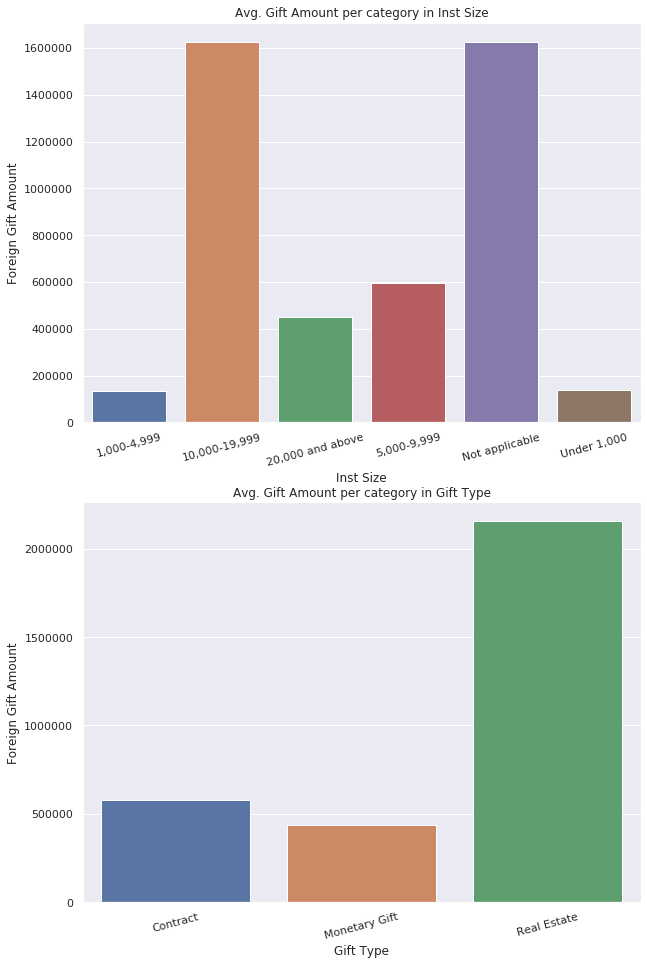

<Figure size 432x288 with 0 Axes>

In [0]:
sns.set()

plt.figure(figsize=(10,25))

for i, col in enumerate(merged_2[plot_list]):
    plt.subplot(3,1,i+1)
    
    # set up figure
    ax = sns.barplot(x=merged_2.groupby(col)['Foreign Gift Amount'].mean().index, 
            y=merged_2.groupby(col)['Foreign Gift Amount'].mean(), orient='v')
    
    # set up title and make human readable
    plt.title('Avg. Gift Amount per category in {}'.format(
        col.title().replace('_', ' ')))
    
    # fix labels
    ax.set(ylabel='Foreign Gift Amount', 
           xlabel=('{}'.format(col.title().replace('_', ' '))))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=15)
    
plt.show()
plt.tight_layout()

Create Feature List and run models for individual donation prediction

In [0]:
remove_cat.extend(['cc_basic_2015'])

keep_cat_var = [i for i in categorical_vars if i not in remove_cat]

In [0]:
keep_list = keep_cat_var + keep_cont_var

In [0]:
merged_2[keep_list].isna().sum()

Gift Type                   0
Country of Giftor           0
inst_control                4
hospital                    4
medical_degree              4
offering_highest_degree     4
inst_size                   4
dist_ug_offered            10
dist_grad_offered          10
remedial_services          10
oncampus_daycare           10
oncampus_required          10
prepaid_tuition            10
Foreign Gift Amount         0
number_applied              0
number_admitted             0
number_enrolled_ft          0
number_enrolled_total       0
Top50                       0
dtype: int64

### Run Models for Individual Donation Predictions

In [0]:
X = merged_2[keep_list]
X = X.dropna()
X = pd.get_dummies(X, drop_first=True)
y = X['Foreign Gift Amount']
X = X.drop(['Foreign Gift Amount'], axis=1)

In [0]:
X.shape

(18354, 174)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=70980)

I will run 3 Regressors:

- RandomForest
- KNN
- GradientBoost

RandomForest Regressor

In [0]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=800, min_samples_leaf=2, 
                           max_features='sqrt', min_impurity_decrease=0.15,
                           min_samples_split=5)
rf.fit(X_train, y_train)

preds_rf = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, preds_rf)
rf_mape = (np.mean(np.abs((y_test - preds_rf) / y_test)) * 100)
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
rf_cvs = cross_val_score(rf, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(rf_mse))
print('Mean Absolute Percentage Error is {}'.format(rf_mape))
print('R2 Train {}'.format(rf_train_score))
print('R2 Test {}'.format(rf_test_score))
print('5-fold Cross Validation Score Average {}'.format(np.mean(rf_cvs)))

Mean Squared Error is 2518574315220.2334
Mean Absolute Percentage Error is 28844.995591785035
R2 Train 0.6024712576144178
R2 Test 0.3651132922163166
5-fold Cross Validation Score Average 0.08022466567219191


Examine Feature Importances for RandomForest Regressor

In [0]:
feature_importances = pd.DataFrame(
    rf.feature_importances_,
    index = X.columns,
    columns=['importance']).sort_values('importance',
    ascending=False
    )
feature_importances.head()

,importance
Country of Giftor_BERMUDA,0.195190
number_enrolled_total,0.093754
number_enrolled_ft,0.092479
number_applied,0.082300
number_admitted,0.073232


KNN Regressor

In [0]:
knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=19)
knn.fit(X_train, y_train)

preds = knn.predict(X_test)

knn_mse = mean_squared_error(y_test, preds)
knn_mape = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
knn_score_train = knn.score(X_train, y_train)
knn_score_test = knn.score(X_test, y_test)
knn_cvs = cross_val_score(knn, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(knn_mse))
print('Mean Absolute Percentage Error is {}'.format(knn_mape))
print('R2 Train {}'.format(knn_score_train))
print('R2 Test {}'.format(knn_score_test))
print('5-fold Cross Validation Score Average {}'.format(np.mean(knn_cvs)))

Mean Squared Error is 3384313985083.694
Mean Absolute Percentage Error is 48737.31432683549
R2 Train 0.31826200164504237
R2 Test 0.14687609132225365
5-fold Cross Validation Score Average 0.00708572788833719


GradientBoost Regressor

In [0]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=300, 
                                validation_fraction=0.15)
gbr.fit(X_train, y_train)

preds = gbr.predict(X_test)

gbr_mse = mean_squared_error(y_test, preds)
gbr_mape = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
train_gbr = gbr.score(X_train, y_train)
score_gbr = gbr.score(X_test, y_test)
gbr_cvs = cross_val_score(gbr, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(gbr_mse))
print('Mean Absolute Percentage Error is {}'.format(gbr_mape))
print('R2 Train {}'.format(train_gbr))
print('R2 Test {}'.format(score_gbr))
print('5-fold Cross Validation Score Average {}'.format(np.mean(gbr_cvs)))

Mean Squared Error is 2946640929293.665
Mean Absolute Percentage Error is 42337.165648280505
R2 Train 0.6913849421038399
R2 Test 0.2572054962546062
5-fold Cross Validation Score Average -0.02950798872267806


Following disappointing numbers for MAPE and Accuracy, I proceeded to use GridSearchCV to optimize models

In [0]:
params = {'n_estimators':np.arange(50, 200, 50), 
          'min_samples_leaf':np.arange(1, 5, 1)}

grd_rf = GridSearchCV(estimator=rf, param_grid=params, n_jobs=-1, cv=5, 
                      return_train_score=True)

grd_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.15,
                                             min_impurity_split=None,
                                             min_samples_leaf=2,
                                             min_samples_split=5,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=800, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [0]:
rf_grd_model = grd_rf.best_estimator_
rf_grd_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.15,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

GridSearchCV Tuned Random Forest Regressor

In [0]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, min_samples_leaf=2, 
                           max_features='sqrt')
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

grid_rf_mse = mean_squared_error(y_test, preds)
grid_rf_mape = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
grid_rf_train_score = rf.score(X_train, y_train)
grid_rf_test_score = rf.score(X_test, y_test)
grid_rf_cvs = cross_val_score(rf, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(grid_rf_mse))
print('Mean Absolute Percentage Error is {}'.format(grid_rf_mape))
print('R2 Train {}'.format(grid_rf_train_score))
print('R2 Test {}'.format(grid_rf_test_score))
print('5-fold Cross Validation Score Average {}'.format(np.mean(grid_rf_cvs)))

Mean Squared Error is 2573172958071.6514
Mean Absolute Percentage Error is 27898.236416458287
R2 Train 0.6067456847277813
R2 Test 0.3513499688948991
5-fold Cross Validation Score Average 0.06750177967346402


In [0]:
params = {'n_neighbors':np.arange(3,7,1),
          'weights':['distance', 'uniform']}

grd_knn = GridSearchCV(estimator=knn, param_grid=params, 
                       n_jobs=-1, cv=5, return_train_score=True)

grd_knn.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=19, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([3, 4, 5, 6]),
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [0]:
grd_knn.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
                    weights='uniform')

GridSearchCV Tuned KNN Regressor

In [0]:
knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=5, algorithm='ball_tree')
knn.fit(X_train, y_train)

preds = knn.predict(X_test)

knn_grid_mse = mean_squared_error(y_test, preds)
knn_grid_mape = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
knn_grid_score_train = knn.score(X_train, y_train)
knn_grid_score_test = knn.score(X_test, y_test)
knn_grid_cvs = cross_val_score(knn, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(knn_grid_mse))
print('Mean Absolute Percentage Error is {}'.format(knn_grid_mape))
print('R2 Train {}'.format(knn_grid_score_train))
print('R2 Test {}'.format(knn_grid_score_test))
print('5-fold Cross Validation Score Average {}'.format(np.mean(knn_grid_cvs)))

Mean Squared Error is 3093586802379.5107
Mean Absolute Percentage Error is 14055.853621796612
R2 Train 0.5783550710681827
R2 Test 0.22016311834180136
5-fold Cross Validation Score Average -0.15644774841851067


In [0]:
params = {'n_estimators':np.arange(10, 50, 10),
          'learning_rate':np.arange(0.4, 1.0, 0.1)}

grd_gbr = GridSearchCV(estimator=gbr, param_grid=params, n_jobs=-1, cv=5, 
                       return_train_score=True)

grd_gbr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=300,
                                                 n_iter_no_change=None,
                 

In [0]:
grd_gbr.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.7, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.15, verbose=0,
                          warm_start=False)

GridSearchCV Tuned GradientBoost Regressor

In [0]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=10, 
                                validation_fraction=0.15, 
                                learning_rate=0.70)
gbr.fit(X_train, y_train)

preds = gbr.predict(X_test)

gbr_grid_mse = mean_squared_error(y_test, preds)
gbr_grid_mape = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
train_gbr_grid = gbr.score(X_train, y_train)
score_gbr_grid = gbr.score(X_test, y_test)
gbr_cvs_grid = cross_val_score(gbr, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(gbr_grid_mse))
print('Mean Absolute Percentage Error is {}'.format(gbr_grid_mape))
print('R2 Train {}'.format(train_gbr_grid))
print('R2 Test {}'.format(score_gbr_grid))
print('5-fold Cross Validation Score Average {}'.format(np.mean(gbr_cvs_grid)))

Mean Squared Error is 2442932067835.9395
Mean Absolute Percentage Error is 64913.61954892576
R2 Train 0.6212188446951878
R2 Test 0.3841813249207532
5-fold Cross Validation Score Average -0.08134190560870339


Summary Table for Individual Donation Predictions

In [0]:
summary_individual = pd.DataFrame(
    {
        'Regression Model':['RandomForest', 'RandomForest GridSearchCV', 
                         'KNN', 'KNN GridSearchCV', 'GradientBoost', 
                         'GradientBoost GridSearchCV'],
     
        'Mean Squared Error':[rf_mse, grid_rf_mse, knn_mse, 
                            knn_grid_mse, gbr_mse, gbr_grid_mse],
     
        'Mean Absolute Percent Error':[rf_mape, grid_rf_mape, knn_mape, 
                                     knn_grid_mape, gbr_mape, gbr_grid_mape],
     
        'R-Squared Train':['{:.2%}'.format(rf_train_score), 
                           '{:.2%}'.format(grid_rf_train_score), 
                           '{:.2%}'.format(knn_score_train),
                           '{:.2%}'.format(knn_grid_score_train), 
                           '{:.2%}'.format(train_gbr), 
                           '{:.2%}'.format(train_gbr_grid)],
     
        'R-Squared Test':['{:.2%}'.format(rf_test_score), 
                          '{:.2%}'.format(grid_rf_test_score), 
                          '{:.2%}'.format(knn_score_test),
                          '{:.2%}'.format(knn_grid_score_test), 
                          '{:.2%}'.format(score_gbr), 
                          '{:.2%}'.format(score_gbr_grid)],
     
        '5-Fold Cross Validation Score':['{:.2%}'.format(np.mean(rf_cvs)),
                                         '{:.2%}'.format(np.mean(grid_rf_cvs)), 
                                         '{:.2%}'.format(np.mean(knn_cvs)), 
                                         '{:.2%}'.format(np.mean(knn_grid_cvs)), 
                                         '{:.2%}'.format(np.mean(gbr_cvs)), 
                                         '{:.2%}'.format(np.mean(gbr_cvs_grid))]
     })

In [0]:
summary_individual.sort_values(by=['5-Fold Cross Validation Score'], ascending=False)

,Regression Model,Mean Squared Error,Mean Absolute Percent Error,R-Squared Train,R-Squared Test,5-Fold Cross Validation Score
0,RandomForest,2.518574e+12,28844.995592,60.25%,36.51%,8.02%
1,RandomForest GridSearchCV,2.573173e+12,27898.236416,60.67%,35.13%,6.75%
2,KNN,3.384314e+12,48737.314327,31.83%,14.69%,0.71%
5,GradientBoost GridSearchCV,2.442932e+12,64913.619549,62.12%,38.42%,-8.13%
4,GradientBoost,2.946641e+12,42337.165648,69.14%,25.72%,-2.95%
3,KNN GridSearchCV,3.093587e+12,14055.853622,57.84%,22.02%,-15.64%


Based on the summary above, the RandomForest Regressor was the best performing model based on Cross Validation score, and Mean Squared Error

Here is the model graphed below:

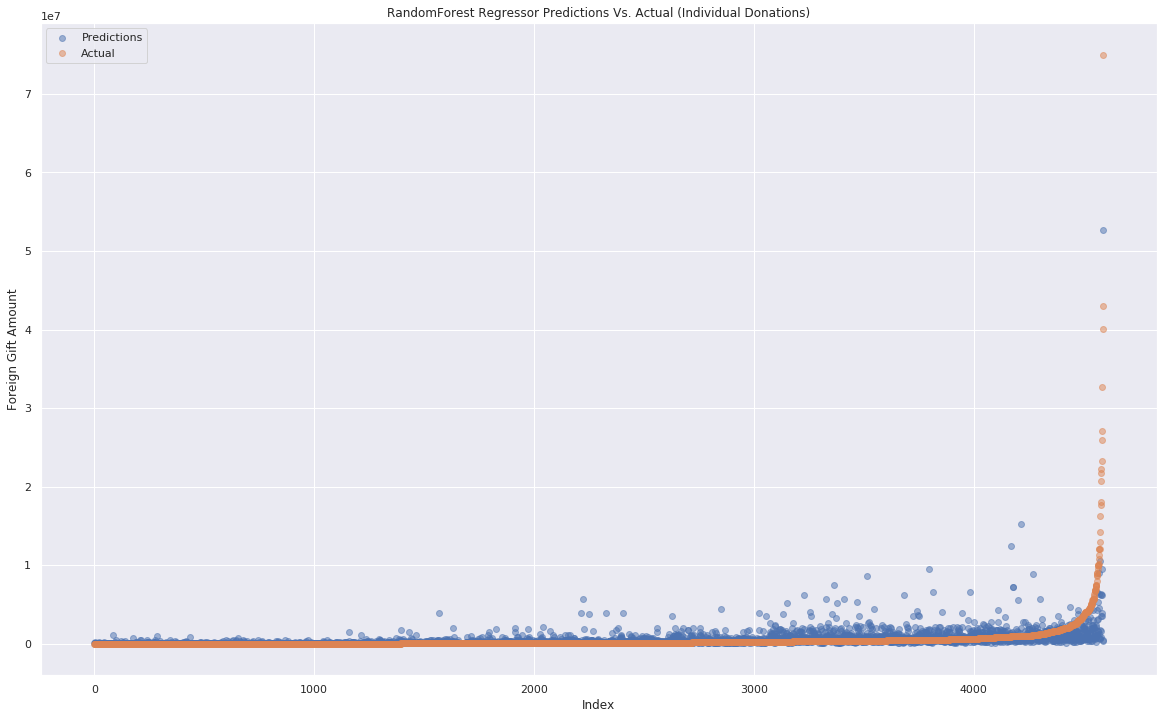

In [0]:
idx = range(X_test.shape[0])
order = y_test.argsort()


plt.figure(figsize=(20,12))
plt.scatter(idx, preds_rf[order], alpha=0.5)
plt.scatter(idx, y_test.iloc[order], alpha=0.5)
plt.title('RandomForest Regressor Predictions Vs. Actual (Individual Donations)')
plt.ylabel('Foreign Gift Amount')
plt.xlabel('Index')
plt.legend(labels=('Predictions', 'Actual'))
plt.show()

### Run Models for Total Donation Predictions

Create Feature List and run models for Total Donation prediction

In [0]:
totals = df2.groupby(['OPEID', 'year'])['Foreign Gift Amount'].sum().reset_index()
totals


,OPEID,year,Foreign Gift Amount
0,107000,2012,4749569.0
1,108100,2012,3546398.0
2,108100,2013,18223614.0
3,108100,2014,9764981.0
4,108100,2015,15773165.0
...,...,...,...
587,3853300,2015,402916.0
588,3853300,2016,316552.0
589,3853300,2017,617000.0
590,4143200,2012,21532410.0


Note that "Country of Giftor" will not be included as the data set is already very small, and the added dimensionality from that feature would hurt the model and performance

In [0]:
merged_totals = pd.merge(totals, df, how='left', left_on=['year', 'OPEID'], right_on=['year', 'opeid'])

In [0]:
totals_2 = pd.merge(merged_totals, df3, how='left', left_on=['year', 'unitid'], right_on=['year', 'IPEDS ID'])

In [0]:
totals_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 0 to 610
Data columns (total 53 columns):
OPEID                             611 non-null int64
year                              611 non-null int64
Foreign Gift Amount               611 non-null float64
unitid                            609 non-null float64
inst_name                         609 non-null object
state_name                        609 non-null object
number_applied                    556 non-null float64
number_admitted                   556 non-null float64
number_enrolled_ft                556 non-null float64
number_enrolled_pt                465 non-null float64
number_enrolled_total             556 non-null float64
offering_highest_level            609 non-null object
inst_control                      609 non-null object
institution_level                 609 non-null object
sector                            609 non-null object
hbcu                              609 non-null object
primarily_postsecondary   

Remove most of the same columns as were removed from individual donation feature list

In [0]:
totals_2.drop(['IPEDS ID', 'University Name', 'inst_name', 'inst_alias',
               'sector', 'hbcu', 'postsec_public_active',
               'postsec_public_active_title_iv', 'year',
               'OPEID', 'opeid', 'state_name', 'inst_system_flag',
               'inst_status', 'offering_undergrad', 'offering_grad',
               'offering_highest_level', 'inst_category', 
               'title_iv_indicator', 'tribal_college', 
               'tuition_guaranteed', 'prepaid_tuition', 
               'tuition_payment_plan', 'primarily_postsecondary', 
               'institution_level', 'employment_services', 
               'placement_services', 'open_public',
               'degree_granting', 'cc_basic_2015', 'academic_counseling',
               'study_abroad', 'oncampus_housing', 'hospital',
               'land_grant', 'member_ncaa', 'unitid'], axis=1, inplace=True)

In [0]:
totals_2['Top50'].fillna(value=0, inplace=True)

In [0]:
missing_list = ['number_applied', 'number_admitted', 
                'number_enrolled_ft', 'number_enrolled_total',
                'number_enrolled_pt']
for column in totals_2[missing_list]:
    totals_2[column].fillna(totals_2[column].mean(), inplace=True)

In [0]:
totals_2.isna().sum()

Foreign Gift Amount        0
number_applied             0
number_admitted            0
number_enrolled_ft         0
number_enrolled_pt         0
number_enrolled_total      0
inst_control               2
medical_degree             2
offering_highest_degree    2
inst_size                  2
dist_ug_offered            3
dist_grad_offered          3
remedial_services          3
oncampus_daycare           3
oncampus_required          3
Top50                      0
dtype: int64

In [0]:
totals_2.shape

(611, 16)

RandomForest Regressor 

In [0]:
rf_2 = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=500, 
                            min_impurity_decrease=0.15, min_samples_split=5)
X_2 = totals_2
X_2 = X_2.dropna()
X_2 = pd.get_dummies(X_2, drop_first=True)
y_2 = X_2['Foreign Gift Amount']
X_2 = X_2.drop(['Foreign Gift Amount'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, 
                                                    random_state=42)

rf_2.fit(X_train, y_train)
preds_rf_2 = rf_2.predict(X_test)

mse_rf = mean_squared_error(y_test, preds_rf_2)
mape_rf = (np.mean(np.abs((y_test - preds_rf_2) / y_test)) * 100)
train_score_rf = rf_2.score(X_train, y_train)
test_score_rf = rf_2.score(X_test, y_test)
cvs_rf = cross_val_score(rf_2, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(mse_rf))
print('Mean Absolute Percentage Error is {}'.format(mape_rf))
print('R2 Train {}'.format(train_score_rf))
print('R2 Test {}'.format(test_score_rf))
print('5-fold Cross Validation Score Average {}'.format(np.mean(cvs_rf)))

Mean Squared Error is 154471439273383.06
Mean Absolute Percentage Error is 362.6717759066664
R2 Train 0.7147959783850752
R2 Test 0.2366039469895147
5-fold Cross Validation Score Average 0.4176605246635029


In [0]:
X_2.shape

(608, 30)

In [0]:
feature_importances_total = pd.DataFrame(
    rf_2.feature_importances_,
    index = X_2.columns,
    columns=['importance']).sort_values('importance',
    ascending=False
    )
feature_importances_total.head()

,importance
number_admitted,0.161534
number_applied,0.137735
number_enrolled_ft,0.131468
number_enrolled_total,0.123581
Top50,0.064914


KNN Regressor

In [0]:
knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)

preds = knn.predict(X_test)

mse_knn = mean_squared_error(y_test, preds)
mape_knn = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
score_train_knn = knn.score(X_train, y_train)
score_test_knn = knn.score(X_test, y_test)
cvs_knn = cross_val_score(knn, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(mse_knn))
print('Mean Absolute Percentage Error is {}'.format(mape_knn))
print('R2 Train {}'.format(score_train_knn))
print('R2 Test {}'.format(score_test_knn))
print('5-fold Cross Validation Score Average {}'.format(np.mean(cvs_knn)))

Mean Squared Error is 312349431632949.06
Mean Absolute Percentage Error is 222.7552291486377
R2 Train 0.9707161641375441
R2 Test -0.5436272516802294
5-fold Cross Validation Score Average 0.24351115139620866


GradientBoost Regressor

In [0]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=20)
gbr.fit(X_train, y_train)

preds = gbr.predict(X_test)

mse_gbr = mean_squared_error(y_test, preds)
mape_gbr = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
gbr_train = gbr.score(X_train, y_train)
gbr_score = gbr.score(X_test, y_test)
cvs_gbr = cross_val_score(gbr, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(mse_gbr))
print('Mean Absolute Percentage Error is {}'.format(mape_gbr))
print('R2 Train {}'.format(gbr_train))
print('R2 Test {}'.format(gbr_score))
print('5-fold Cross Validation Score Average {}'.format(np.mean(cvs_gbr)))

Mean Squared Error is 474401008259143.06
Mean Absolute Percentage Error is 497.9905289572066
R2 Train 0.7220570546650026
R2 Test -1.3444842551656566
5-fold Cross Validation Score Average 0.2528707743702827


The numbers for MAPE and Accuracy were slightly better on average with this model, but even the best performing model (RandomForest Regressor) is failing to generalize, therefore I will once again use GridSearchCV to optimize models

In [0]:
params = {'min_samples_split':np.arange(1,5,1),
          'min_samples_leaf':np.arange(1,5,1)}

grd_rf = GridSearchCV(estimator=rf, param_grid=params, n_jobs=-1, cv=5, 
                      return_train_score=True)

grd_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=2,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [0]:
model = grd_rf.best_estimator_
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

GridSearchCV Tuned RandomForest Regressor for Total Donation

In [0]:
rf = RandomForestRegressor(n_jobs=-1, max_features='sqrt', n_estimators=500, 
                            min_impurity_decrease=0.15, min_samples_leaf=2)

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

mse_rf_grid = mean_squared_error(y_test, preds)
mape_rf_grid = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
train_score_rf_grid = rf.score(X_train, y_train)
test_score_rf_grid = rf.score(X_test, y_test)
cvs_rf_grid = cross_val_score(rf, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(mse_rf_grid))
print('Mean Absolute Percentage Error is {}'.format(mape_rf_grid))
print('R2 Train {}'.format(train_score_rf_grid))
print('R2 Test {}'.format(test_score_rf_grid))
print('5-fold Cross Validation Score Average {}'.format(np.mean(cvs_rf_grid)))

Mean Squared Error is 161525699819634.8
Mean Absolute Percentage Error is 384.93111800308475
R2 Train 0.6457258315950851
R2 Test 0.2017418735651486
5-fold Cross Validation Score Average 0.4210340373259783


In [0]:
params = {'n_neighbors':np.arange(3,25,1)}

grd_knn = GridSearchCV(estimator=knn, param_grid=params, 
                       n_jobs=-1, cv=5, return_train_score=True)

grd_knn.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=3, p=2,
                                           weights='distance'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [0]:
grd_knn.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                    weights='distance')

GridSearchCV Tuned KNN Regressor for Total Donation

In [0]:
knn = KNeighborsRegressor(n_jobs=-1, n_neighbors=24, weights='distance')
knn.fit(X_train, y_train)

preds = knn.predict(X_test)

mse_knn_grid = mean_squared_error(y_test, preds)
mape_knn_grid = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
score_train_knn_grid = knn.score(X_train, y_train)
score_test_knn_grid = knn.score(X_test, y_test)
cvs_knn_grid = cross_val_score(knn, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(mse_knn_grid))
print('Mean Absolute Percentage Error is {}'.format(mape_knn_grid))
print('R2 Train {}'.format(score_train_knn_grid))
print('R2 Test {}'.format(score_test_knn_grid))
print('5-fold Cross Validation Score Average {}'.format(np.mean(cvs_knn_grid)))

Mean Squared Error is 272251144218405.6
Mean Absolute Percentage Error is 346.7025084734951
R2 Train 0.9716050548438837
R2 Test -0.3454619824969245
5-fold Cross Validation Score Average 0.33248331202272075


In [0]:
params = {'n_estimators':np.arange(10, 100, 10),
          'learning_rate':np.arange(0.1, 1.0, 0.1)}

grd_gbr = GridSearchCV(estimator=gbr, param_grid=params, n_jobs=-1, cv=5, 
                       return_train_score=True)

grd_gbr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=20,
                                                 n_iter_no...
                            

In [0]:
grd_gbr.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=30,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

GridSearchCV Tuned GradientBoost Regressor for Total Donation

In [0]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=30, learning_rate=0.2)

gbr.fit(X_train, y_train)

preds = gbr.predict(X_test)

mse_gbr_grid = mean_squared_error(y_test, preds)
mape_gbr_grid = (np.mean(np.abs((y_test - preds) / y_test)) * 100)
gbr_train_grid = gbr.score(X_train, y_train)
gbr_score_grid = gbr.score(X_test, y_test)
cvs_gbr_grid = cross_val_score(gbr, X_test, y_test, cv=5)

print('Mean Squared Error is {}'.format(mse_gbr_grid))
print('Mean Absolute Percentage Error is {}'.format(mape_gbr_grid))
print('R2 Train {}'.format(gbr_train_grid))
print('R2 Test {}'.format(gbr_score_grid))
print('5-fold Cross Validation Score Average {}'.format(np.mean(cvs_gbr_grid)))

Mean Squared Error is 186808450120945.12
Mean Absolute Percentage Error is 332.3022109864825
R2 Train 0.9145330902053223
R2 Test 0.0767948161669747
5-fold Cross Validation Score Average 0.19459798717905896


Summary Table for Total Donation Predictions

In [0]:
summary_total = pd.DataFrame(
    {
        'Regression Model':['RandomForest', 
                         'RandomForest GridSearchCV', 
                         'KNN', 'KNN GridSearchCV',
                         'GradientBoost', 
                         'GradientBoost GridSearchCV'],
     
        'Mean Squared Error': [mse_rf, mse_rf_grid, mse_knn, 
                            mse_knn_grid, mse_gbr, mse_gbr_grid],
     
        'Mean Absolute Percent Error': [mape_rf, mape_rf_grid, mape_knn, 
                                     mape_knn_grid, mape_gbr, mape_gbr_grid],
     
        'R-Squared Train':['{:.2%}'.format(train_score_rf), 
                           '{:.2%}'.format(train_score_rf_grid), 
                           '{:.2%}'.format(score_train_knn),
                           '{:.2%}'.format(score_train_knn_grid), 
                           '{:.2%}'.format(gbr_train), 
                           '{:.2%}'.format(gbr_train_grid)],
     
        'R-Squared Test':['{:.2%}'.format(test_score_rf), 
                          '{:.2%}'.format(test_score_rf_grid), 
                          '{:.2%}'.format(score_test_knn),
                          '{:.2%}'.format(score_test_knn_grid), 
                          '{:.2%}'.format(gbr_score), 
                          '{:.2%}'.format(gbr_score_grid)],
     
        '5-Fold Cross Validation Score':['{:.2%}'.format(np.mean(cvs_rf)), 
                                         '{:.2%}'.format(np.mean(cvs_rf_grid)),
                                         '{:.2%}'.format(np.mean(cvs_knn)), 
                                         '{:.2%}'.format(np.mean(cvs_knn_grid)),
                                         '{:.2%}'.format(np.mean(cvs_gbr)), 
                                         '{:.2%}'.format(np.mean(cvs_gbr_grid))]
     })

In [0]:
summary_total.sort_values(by=['5-Fold Cross Validation Score'], ascending=False)

,Regression Model,Mean Squared Error,Mean Absolute Percent Error,R-Squared Train,R-Squared Test,5-Fold Cross Validation Score
1,RandomForest GridSearchCV,1.615257e+14,384.931118,64.57%,20.17%,42.10%
0,RandomForest,1.544714e+14,362.671776,71.48%,23.66%,41.77%
3,KNN GridSearchCV,2.722511e+14,346.702508,97.16%,-34.55%,33.25%
4,GradientBoost,4.744010e+14,497.990529,72.21%,-134.45%,25.29%
2,KNN,3.123494e+14,222.755229,97.07%,-54.36%,24.35%
5,GradientBoost GridSearchCV,1.868085e+14,332.302211,91.45%,7.68%,19.46%


From this summary, the best model based on Cross-Validation score was the RandomForest Regressor. 

Here it is graphed below:

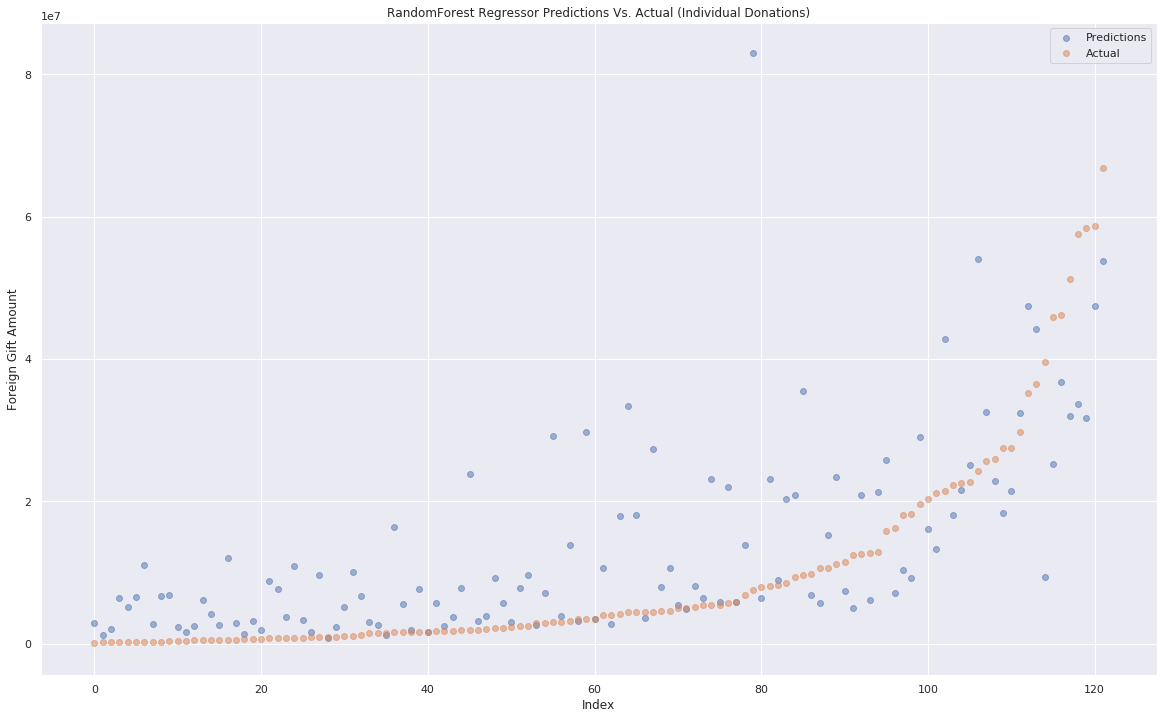

In [0]:
idx = range(X_test.shape[0])
order = y_test.argsort()


plt.figure(figsize=(20,12))
plt.scatter(idx, preds_rf_2[order], alpha=0.5)
plt.scatter(idx, y_test.iloc[order], alpha=0.5)
plt.title('RandomForest Regressor Predictions Vs. Actual (Individual Donations)')
plt.ylabel('Foreign Gift Amount')
plt.xlabel('Index')
plt.legend(labels=('Predictions', 'Actual'))
plt.show()

###Conclusion

After exhaustive tuning and repeated attempts to improve model performance, it can be said that for this project, the prediction results for both individual and total donations reflect poor predictors. 

Additionally, the targets in both cases (Individual and Total donations) measured in 'Foreign Gift Amount", is a difficult target to predict, and many factors likely contribute to a specific donation amount. These could be factors that are impossible to know or measure (i.e. reasons why someone/some entity would donate vs. not donate) reliably.

The explanatory power of these models was perhaps the greatest outcome in this project. Using the feature importance method of the Random Forest model, the explanatory power of the model can be seen. In each case, the continuous variables regarding enrollment seemed to be the most significant features involved. In the individual donation instance, the country feature was most important.

For interested stakeholders, this project was unable to predict the 2 target variables of individual donations, and total donations. Again, this is due to the poor predictive power of the features, and difficult target to predict. Despite tuning, all models overfit and failed to generalize. The Mean Squared Error and Mean Absolute Error Percentage for Regression never came down enough to be reliable for the use-case I suggested at the outset: predicting donation amounts with the intent to plan departmental goal-setting for fundraising.

In closing, I should mention the fact that my project did not address the fact that this was a project dealing with time series data. This project would be of interest with new features and with consideration of this time series component. 

